In [1]:
function rhs=T(n,x)
if (n==0) rhs=1; endif
if (n==1) rhs=x; endif
if (n>1)
rhs=2*x*T(n-1,x)-T(n-2,x);
endif
endfunction

function rhs=dT(n,x)
if (n==0) rhs=0; endif
if (n==1) rhs=1; endif
if (n==2) rhs=4*x; endif
if (n>2)
rhs=2*T(n-1,x)+2*x*dT(n-1,x)-dT(n-2,x);
endif
endfunction

function rhs=ddT(n,x)
if (n==0) rhs=0; endif
if (n==1) rhs=0; endif
if (n==2) rhs=4; endif
if (n==3) rhs=24*x; endif
if (n>3)
rhs=4*dT(n-1,x)+2*x*ddT(n-1,x)-ddT(n-2,x);
endif
endfunction

%%Define the function f
function rhs=f(n,h,t,y) 
% n: the number of ODE in ODE system
% h: step-size    
    rhs=zeros(1,2*n);
    rhs(1)=0;
    rhs(n)=0;
    for i=2:n-1
        rhs(i)=1+y(i)^2*y(n+i)-4*y(i)+ 1/50 *(1/h^2 * y(i-1)+(-2/h^2)*y(i)+1/h^2 * y(i+1));
    endfor
    
    rhs(n+1)=0;
    rhs(2*n)=0;
    for i=2:n-1
        rhs(n+i)=-y(i)^2*y(n+i)+3*y(i)+ 1/50 *(1/h^2 * y(n+i-1)+(-2/h^2)*y(n+i)+1/h^2 * y(n+i+1));
    endfor
    
endfunction

In [20]:
%% RKC method for diffusion problem
function [h,t,y]=rkc_diffusion(a,b,y0,N,s)
%%Input   %a,b: starting, final time 
          %y0: initial value
          %N: number of interval in x-axis
          
          %s: number of stages
%%Output  %h: stepsize
          %t: timegrid
          %y: numerical solution
    h = (b-a)/N;
    timestep = 10/(2*N+1);
    t = a:timestep:b;    
    epsilon = 0.05;  %damping parameter    
    w0 = 1+epsilon/s^2;
    w1 = dT(s,w0)/ddT(s,w0);
    %%Define coefficients
    b = a = mu = nu = c= mu_t = gamma_t = zeros(s+1,1);
    b(1) =  b(2) = b(3) = ddT(2,w0) / (dT(2,w0) ^2 );
    for i=4:s+1
        b(i)=ddT(i-1,w0)/((dT(i-1,w0))^2);
    endfor
    
    % a_j+1=1-b_{j+1}*T_j(w0)
    for i=2:s+1
        a(i)=1-b(i)*T(i-1,w0);
    endfor    

    %mu_j+1=-2b_jw_0/b_{j-1}
    for i=3:s+1
        mu(i) = 2 * w0 * b(i) / b(i-1);
    endfor
    
    %nu_j=-b_j/(b_{j-2})
    for i = 3:s+1
        nu(i) = -b(i) / b(i-2); 
    endfor
    
    %c_j=w1*b_j*T'_j(w0)
    for i=2:s
        c(i) = w1 * b(i) * dT(i-1,w0);
    endfor    
    c(s) = 1;
    
    %mu_t(i) = 2 * w1*b(i) / b(i-1)
    mu_t(2) = b(2)*w1;
    for i = 3:s+1
        mu_t(i) = 2 * w1 *b(i) / b(i-1);
    endfor
    
    %gamma_t= -a_{j-1} *mu_t(j)
    gamma_t(2) = c(2);
    for i = 3:s+1
        gamma_t(i) = - a(i-1) * mu_t(i);
    endfor
    
    %%%% Main loop
    g = zeros(s+1,2*N+2);
    y=zeros(2*N+2,2*N+2);
    y(1,:) = y0;
    for i = 1:2*N+1
        g(1,:) = y(i,:);
        g(2,:) = g(1,:) + mu_t(2) * timestep * f(N+1,h,t(1)+c(1)*timestep,g(1,:));
        for j=3:s+1
            g(j,:) = (1-mu(j)-nu(j)) * g(1,:) + mu(j)* g(j-1,:) + nu(j)*g(j-2,:) + mu_t(j) * timestep * f(N+1,h,t(1)+c(1)*timestep,g(j-1,:)) + gamma_t(j) * timestep * f(N+1,h,t(1)+c(1)*timestep,g(1,:));
        endfor
        y(i+1,:) = g(s+1,:);
    endfor      
endfunction

In [21]:
%%Plot the numerical solution.
a=0;
b=1;
N=50;
s=10;
h=(b-a)/N;
y0=zeros(1,2*N+2);
for i=1:N+1
    y0(i)=1+sin(2*pi/(N) * (i-1));
endfor
for i=1:N+1
    y0(N+1+i)=3;
endfor
[h,t,y] = rkc_diffusion(a,b,y0,N,s);

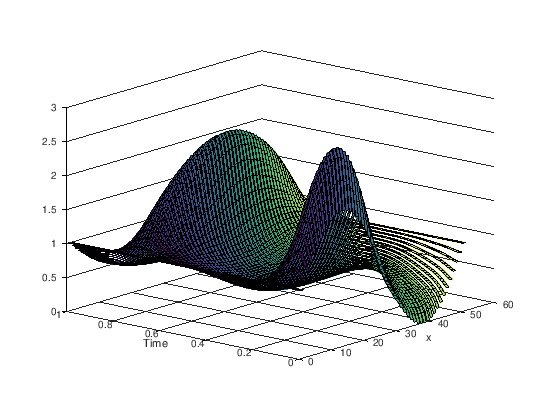

In [23]:
xgrid=linspace(0,1,2*(N+1));
%ribbon(xgrid',y)
ribbon(xgrid',y(:,1:N+1));
view([-50 20])
xlabel('x')
ylabel('Time')


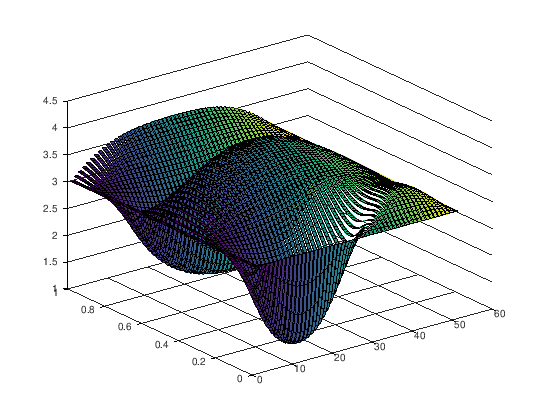

In [25]:
ribbon(xgrid',y(:,N+2:2*N+2));